In [29]:
from typing import Dict, List
import warnings
warnings.filterwarnings("ignore", message="A parameter name that contains")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import textstat
import joblib

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
def load_and_prepare_data(path: str) -> pd.DataFrame:
    """
    Load dataset and rename columns.

    Args:
        path (str): File path to CSV dataset.

    Returns:
        pd.DataFrame: Prepared dataframe with columns ['text', 'label'].
    """
    data = pd.read_csv(path)
    data.rename(columns={'sentence': 'text', 'emotion': 'label'}, inplace=True)
    return data

data = load_and_prepare_data(r"D:\Grad_Proj\project\combined_emotion.csv")
data

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
...,...,...
422741,i begun to feel distressed for you,fear
422742,i left feeling annoyed and angry thinking that...,anger
422743,i were to ever get married i d have everything...,joy
422744,i feel reluctant in applying there because i w...,fear


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    422746 non-null  object
 1   label   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [32]:
data['No_of_Chars'] = data['text'].apply(len)
data['No_of_Words'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis= 1).apply(len)
data['No_of_Sents'] = data.apply(lambda row: nltk.sent_tokenize(row['text']), axis= 1).apply(len)

data.describe()

,No_of_Chars,No_of_Words,No_of_Sents
count,422746.000000,422746.000000,422746.0
mean,97.033980,19.220179,1.0
std,56.198156,11.057121,0.0
min,2.000000,1.000000,1.0
25%,54.000000,11.000000,1.0
50%,86.000000,17.000000,1.0
75%,128.000000,25.000000,1.0
max,830.000000,178.000000,1.0


In [33]:
def encode_labels(df: pd.DataFrame, col: str) -> (pd.DataFrame, LabelEncoder):
    """
    Encode categorical labels to integers.

    Args:
        df (pd.DataFrame): Input dataframe.
        col (str): Column name of labels.

    Returns:
        tuple: Dataframe with encoded labels, fitted LabelEncoder.
    """
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return df, le

data, le = encode_labels(data, 'label')


In [34]:
""" cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes') """

" cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']\nplt.figure(figsize=(12,8))\nfg = sns.countplot(x= data['label'], palette= cols_color)\nfg.set_title('count plot of classes')\nfg.set_xlabel('classes')\nfg.set_ylabel('count of classes') "

In [35]:
""" plt.figure(figsize=(12,8))
fg = sns.pairplot(data= data, hue= 'label', palette= cols_color)
plt.show(fg) """

" plt.figure(figsize=(12,8))\nfg = sns.pairplot(data= data, hue= 'label', palette= cols_color)\nplt.show(fg) "

In [36]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [37]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    """
    تحويل POS tag من شكل NLTK إلى الشكل المطلوب من WordNetLemmatizer.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # الافتراضي

In [38]:
def preprocess_text(text: str) -> str:
    """
    تنظيف النص مع تحسين lemmatization باستخدام POS tagging.
    """
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ]
    return ' '.join(lemmatized_words)

data['lemmatized_words'] = data['text'].apply(preprocess_text)

In [39]:
def extract_pos_tags(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    return ' '.join(tag for word, tag in pos_tags)

data['pos_tags'] = data['lemmatized_words'].apply(extract_pos_tags)

tfidf_pos = TfidfVectorizer()
X_pos = tfidf_pos.fit_transform(data['pos_tags'])
data['pos_tags']

0                                           NN RB JJ NN VBD
1         JJ NN JJ JJ NN IN JJ NN JJ NN RB VBP JJ NN RB ...
2                                            VB NN NN NN NN
3                                              NN VBP NN VB
4         VB PRP RB JJ NN VB NN NN NN NN NN NN VBP NN NN...
                                ...                        
422741                                            VB NNS JJ
422742                              VB NN IN JJ NN NN JJ NN
422743    RB VB JJ NN NN VBP VB RB VBP RB RB VBP JJ NN N...
422744                 NN JJ NN VBP JJ VBP NN VBP JJS CD NN
422745                                    JJ NN NN IN NN NN
Name: pos_tags, Length: 422746, dtype: object

In [40]:
""" cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']
plt.figure(figsize=(12,8))
fg = sns.countplot(x= data['label'], palette= cols_color)
fg.set_title('count plot of classes')
fg.set_xlabel('classes')
fg.set_ylabel('count of classes') """

" cols_color = ['black', 'blue', 'red', 'green', 'purple', 'cyan']\nplt.figure(figsize=(12,8))\nfg = sns.countplot(x= data['label'], palette= cols_color)\nfg.set_title('count plot of classes')\nfg.set_xlabel('classes')\nfg.set_ylabel('count of classes') "

In [41]:
""" all_words = " ".join(sentence for sentence in data['lemmatized_words'])
all_words

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show() """

' all_words = " ".join(sentence for sentence in data[\'lemmatized_words\'])\nall_words\n\nwordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)\n\nplt.figure(figsize=(12,8))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.show() '

In [42]:
tfidf = TfidfVectorizer(max_features=1000, max_df=0.9, min_df=2, stop_words='english', ngram_range=(1, 2))
sia = SentimentIntensityAnalyzer()

def vectorize_text(df: pd.DataFrame, text_col: str, vectorizer: TfidfVectorizer):
    """
    Vectorize text column using TF-IDF.

    Args:
        df (pd.DataFrame): Dataframe containing text data.
        text_col (str): Name of the column with preprocessed text.
        vectorizer (TfidfVectorizer): Initialized vectorizer.

    Returns:
        sparse matrix: TF-IDF features matrix.
    """
    X = vectorizer.fit_transform(df[text_col])
    return X

sampled_data = data.sample(frac=0.3, random_state=42)
X = vectorize_text(sampled_data, 'lemmatized_words', tfidf)
y = sampled_data['label']


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_balanced))


Before SMOTE: [14272 11980 34326  8252 28936  3693]
After SMOTE: [34326 34326 34326 34326 34326 34326]


In [44]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({2: 34326, 4: 28936, 0: 14272, 1: 11980, 3: 8252, 5: 3693})
After SMOTE: Counter({2: 34326, 1: 34326, 0: 34326, 4: 34326, 5: 34326, 3: 34326})


In [45]:
row = X[0].toarray().flatten()
for i, val in enumerate(row):
    if val != 0:
        print(f'index {i}: {val}')


index 80: 0.5824834849061667
index 134: 0.5461345627470632
index 262: 0.08891625239402497
index 328: 0.25158305605751424
index 455: 0.4915822572203815
index 581: 0.22270334424009006


Accuracy: 0.7739
Test set F1 Score (weighted): 0.7769
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      3568
           1       0.74      0.73      0.74      2995
           2       0.83      0.79      0.81      8582
           3       0.60      0.75      0.67      2063
           4       0.86      0.79      0.82      7234
           5       0.50      0.65      0.57       923

    accuracy                           0.77     25365
   macro avg       0.71      0.75      0.73     25365
weighted avg       0.78      0.77      0.78     25365

              precision    recall  f1-score   support

       anger       0.74      0.79      0.76      3568
        fear       0.74      0.73      0.74      2995
         joy       0.83      0.79      0.81      8582
        love       0.60      0.75      0.67      2063
         sad       0.86      0.79      0.82      7234
     suprise       0.50      0.65      0.57       923

    accuracy           

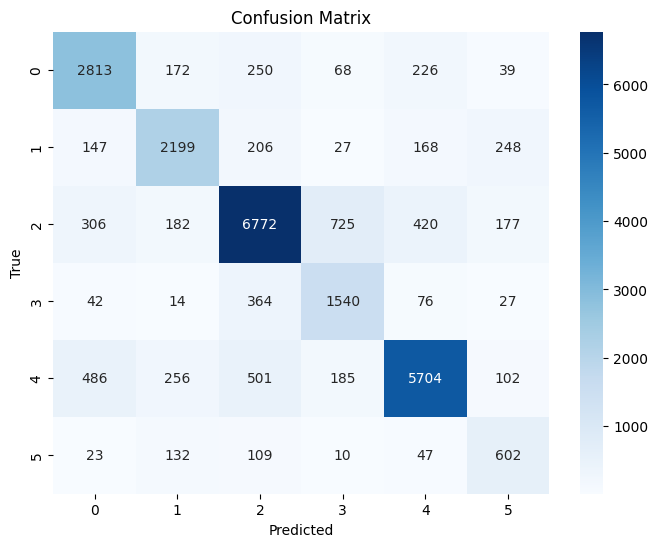

In [46]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    """
    Train Random Forest and evaluate on test set.

    Args:
        X_train, y_train: Training features and labels.
        X_test, y_test: Testing features and labels.

    Returns:
        model: Trained Random Forest model.
    """

    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test set F1 Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return model

random_forest_model = train_and_evaluate(X_train_balanced, y_train_balanced, X_test, y_test)


comparison between models


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB


In [48]:
""" models = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    print("-" * 30) """

' models = {\n    \'Random Forest\': RandomForestClassifier(),\n    \'Naive Bayes\': MultinomialNB(),\n    \'SVM\': SVC(),\n    \'KNN\': KNeighborsClassifier()\n}\n\nfor name, model in models.items():\n    model.fit(X_train_balanced, y_train_balanced)\n    y_pred = model.predict(X_test)\n    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")\n    print(f"{name} F1 Score: {f1_score(y_test, y_pred, average=\'weighted\'):.2f}")\n    print("-" * 30) '

In [49]:
import joblib

joblib.dump(random_forest_model, './models/random_forest_model.pkl')
joblib.dump(tfidf, './models/tfidf_vectorizer.pkl')
joblib.dump(le, './models/label_encoder.pkl')


['./models/label_encoder.pkl']

In [50]:
def predict_emotion(text, model, vectorizer, label_encoder):
    processed = preprocess_text(text)
    
    vect_text = vectorizer.transform([processed])
    
    prediction = model.predict(vect_text)
    return label_encoder.inverse_transform(prediction)[0]

print(predict_emotion("I feel so happy and joyful today!", random_forest_model, tfidf, le))


joy


In [51]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


Before SMOTE: Counter({2: 34326, 4: 28936, 0: 14272, 1: 11980, 3: 8252, 5: 3693})
After SMOTE: Counter({2: 34326, 1: 34326, 0: 34326, 4: 34326, 5: 34326, 3: 34326})


In [52]:
books_db = pd.read_csv("./data/books.csv", index_col='book_id')
books_db = books_db[['original_title', 'authors']]
books_db.rename(columns={'original_title': 'title'}, inplace=True)
books_db




,title,authors
book_id,,
2767052,The Hunger Games,Suzanne Collins
3,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré"
41865,Twilight,Stephenie Meyer
2657,To Kill a Mockingbird,Harper Lee
4671,The Great Gatsby,F. Scott Fitzgerald
...,...,...
7130616,Bayou Moon,Ilona Andrews
208324,Means of Ascent,Robert A. Caro
77431,The Mauritius Command,Patrick O'Brian


In [53]:
books_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 2767052 to 8914
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    9415 non-null   object
 1   authors  10000 non-null  object
dtypes: object(2)
memory usage: 234.4+ KB


In [54]:
books_db.dropna(inplace=True)

In [55]:
articles_db = pd.read_csv("./data/articles.csv", index_col='id')  # يحتوي على title, link
articles_db


,url,title
id,,
1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...
2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...
3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru..."
4,https://towardsdatascience.com/dates-and-subqu...,Dates and Subqueries in SQL
5,https://towardsdatascience.com/temporal-differ...,Temporal Differences with Python: First Sample...
...,...,...
2494,https://medium.com/swlh/brian-chesky-is-an-exa...,Brian Chesky is an Example of What it Means to...
2495,https://medium.com/swlh/5-red-flags-of-online-...,5 Red Flags of Online Business Gurus
2496,https://writingcooperative.com/recognizing-the...,Recognizing These Three Realities Can Help Set...


In [56]:
articles_db.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2498 entries, 1 to 2498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     2498 non-null   object
 1   title   2498 non-null   object
dtypes: object(2)
memory usage: 58.5+ KB


In [57]:
model = joblib.load("./models/random_forest_model.pkl")
vectorizer = joblib.load("./models/tfidf_vectorizer.pkl")

In [58]:
from sklearn.base import BaseEstimator

def classify_emotions(
    df: pd.DataFrame,
    text_column: str,
    model: BaseEstimator,
    vectorizer: TfidfVectorizer,
    le: LabelEncoder,
    positive_emotions: List[str] = ["joy", "love", "surprise"],
    save_path: str = None
) -> pd.DataFrame:
    """
    Classifies emotions in a text column and returns only rows with positive emotions.

    Args:
        df (pd.DataFrame): DataFrame containing the texts.
        text_column (str): Name of the column containing the texts (e.g., "title" or "book_title").
        model (BaseEstimator): Trained emotion classification model.
        vectorizer (TfidfVectorizer): TF-IDF vectorizer.
        le (LabelEncoder): Label encoder used to decode emotion labels.
        positive_emotions (List[str], optional): List of emotions considered positive.
        save_path (str, optional): If provided, the filtered DataFrame will be saved as a CSV file to this path.

    Returns:
        pd.DataFrame: DataFrame containing only the texts with positive emotions.
    """ 

    if text_column not in df.columns:
        raise ValueError(f"The column '{text_column}' not exists in Dataframe")

    df['clean_text'] = df[text_column].apply(preprocess_text)

    X_text = vectorizer.transform(df['clean_text'])


    predicted = model.predict(X_text)
    df['emotion'] = le.inverse_transform(predicted)

    df_filtered = df[df['emotion'].isin(positive_emotions)]


    if save_path:
        df_filtered.to_csv(save_path, index=False)

    return df_filtered


In [59]:
try:
    df_clean = classify_emotions(
        df=books_db,
        text_column="title",
        model=model,
        vectorizer=vectorizer,
        le=le,
        save_path="./data/classified_books.csv"
    )
except ValueError as e:
    print(str(e))


In [60]:
try:
    df_clean = classify_emotions(
        df=articles_db,
        text_column="title",
        model=model,
        vectorizer=vectorizer,
        le=le,
        save_path="./data/classified_articles.csv"
    )
except ValueError as e:
    print(str(e))


In [61]:
def filter_by_keywords(df: pd.DataFrame, include_keywords=None, exclude_keywords=None) -> pd.DataFrame:
    """
    Filter content based on keywords.
    
    Args:
        df (pd.DataFrame): Content Table.
        include_keywords (list): Words that the text must contain.
        exclude_keywords (list): Words that must not be in the text.
    
    Returns:
        pd.DataFrame: Content after filtering.
    """
    if include_keywords:
        pattern = '|'.join(include_keywords)
        df = df[df['title'].str.contains(pattern, case=False, na=False)]
    
    if exclude_keywords:
        pattern = '|'.join(exclude_keywords)
        df = df[~df['title'].str.contains(pattern, case=False, na=False)]

    return df

In [62]:
mood_map = {
    'sadness': ['joy', 'surprise'],
    'anger': ['love', 'joy'],
    'fear': ['love', 'joy'],
    'joy': ['joy','surprise', 'love'],
    'surprise': ['love', 'joy'],
    'love': ['joy', 'love', 'surprise']
    }

In [63]:

def recommend_content_filtered(
    user_text: str,
    model,
    vectorizer,
    label_encoder,
    rec_db: pd.DataFrame,
    include_keywords=None,
    exclude_keywords=None
) -> pd.DataFrame:
    """
    #Content recommendation with optional keyword filtering.
    """
    # تنظيف أسماء الأعمدة من المسافات الزائدة
    rec_db.columns = rec_db.columns.str.strip()

    # التأكد من وجود الأعمدة المطلوبة
    if 'predicted_emotion' not in rec_db.columns or 'original_title' not in rec_db.columns:
        raise KeyError("⚠️ Sure the data contains columns: 'original_title' و 'predicted_emotion'.")

    # التنبؤ بالمشاعر للنص
    user_emotion = predict_emotion(user_text, model, vectorizer, label_encoder)
    print(f"🔍 Detected Emotion: {user_emotion}")

    # تحديد المشاعر المستهدفة بناءً على mood_map
    target_emotions = mood_map.get(user_emotion, ['joy', 'calm', 'confidence'])

    # ترشيح المحتوى بناءً على المشاعر
    recommended = rec_db[rec_db['predicted_emotion'].isin(target_emotions)]

    # فلترة المحتوى بناءً على الكلمات
    filtered = filter_by_keywords(recommended, include_keywords, exclude_keywords)

    # في حالة عدم وجود نتائج بعد الفلترة
    if filtered.empty:
        print("⚠️ No content meets the filtering criteria. Showing unfiltered results.")
        return recommended[['original_title', 'authors','predicted_emotion']].sample(min(3, len(recommended)))

    return filtered[['original_title', 'authors', 'predicted_emotion']].sample(min(3, len(filtered)))



In [64]:
def recommend_books(emotion: str, top_n: int = 5) -> List[Dict]:
    df = pd.read_csv("./data/classified_books.csv")  

    if "emotion" not in df.columns:
        df["emotion"] = df["title"].apply(predict_emotion)

    target_emotions = mood_map.get(emotion, ["joy", "love", "surprise"])

    recommended = df[df["emotion"].isin(target_emotions)].head(top_n)

    return recommended[["title", "authors", "emotion"]].to_dict(orient="records")


In [65]:
def recommend_articles(emotion: str, top_n: int = 5) -> List[Dict]:
    df = pd.read_csv("./data/classified_articles.csv")

    if "emotion" not in df.columns:
        df["emotion"] = df["title"].apply(predict_emotion)

    target_emotions = mood_map.get(emotion, ["joy", "love", "surprise"])

    recommended = df[df["emotion"].isin(target_emotions)].head(top_n)

    return recommended[["title", "url", "emotion"]].to_dict(orient="records")


In [66]:
def recommend_content(emotion: str, top_n: int = 5) -> Dict[str, List[Dict]]:
    books = recommend_books(emotion)[:top_n]
    articles = recommend_articles(emotion)[:top_n]
    return {
        "books": books,
        "articles": articles
    }


In [67]:
results = recommend_content(emotion="sad")

print("Books:")
for item in results.get('books', []):
    print(f"- Title: {item.get('title')}, Authors: {item.get('authors')}, Emotion: {item.get('emotion')}")

print("\nArticles:")
for item in results.get('articles', []):
    print(f"- Title: {item.get('title')}, Link: {item.get('link')}, Emotion: {item.get('emotion')}")


Books:
- Title: The Lovely Bones, Authors: Alice Sebold, Emotion: love
- Title: Gone Girl, Authors: Gillian Flynn, Emotion: joy
- Title: The Time Traveler's Wife, Authors: Audrey Niffenegger, Emotion: joy
- Title: Life of Pi, Authors: Yann Martel, Emotion: joy
- Title: Brave New World, Authors: Aldous Huxley, Emotion: joy

Articles:
- Title: Don’t Become a Full-Time Content Creator If You Have Low-Risk Tolerance, Link: None, Emotion: joy
- Title: <strong class="markup--strong markup--h3-strong">How My MBA Made Me a Better Fiction Writer</strong>, Link: None, Emotion: joy
- Title: How to Start Your Novel with Momentum to Finish It, Link: None, Emotion: joy
- Title: <strong class="markup--strong markup--h3-strong">Using Propensity-Score Matching to Build Leading Indicators</strong>, Link: None, Emotion: joy
- Title: How I’ve Showed Up To Write on the Internet for 1000 Days, Link: None, Emotion: joy


In [68]:
results = recommend_books(emotion="sad")
for book in results:
    print(book)

{'title': 'The Lovely Bones', 'authors': 'Alice Sebold', 'emotion': 'love'}
{'title': 'Gone Girl', 'authors': 'Gillian Flynn', 'emotion': 'joy'}
{'title': "The Time Traveler's Wife", 'authors': 'Audrey Niffenegger', 'emotion': 'joy'}
{'title': 'Life of Pi', 'authors': 'Yann Martel', 'emotion': 'joy'}
{'title': 'Brave New World', 'authors': 'Aldous Huxley', 'emotion': 'joy'}


In [69]:
results = recommend_articles(emotion="sad")
for article in results:
    print(article)


{'title': 'Don’t Become a Full-Time Content Creator If You Have Low-Risk Tolerance', 'url': 'https://medium.com/swlh/dont-become-a-full-time-content-creator-if-you-have-low-risk-tolerance-13fa2f77791a', 'emotion': 'joy'}
{'title': '<strong class="markup--strong markup--h3-strong">How My MBA Made Me a Better Fiction\xa0Writer</strong>', 'url': 'https://writingcooperative.com/how-my-mba-made-me-a-better-fiction-writer-d222bc61a5b0', 'emotion': 'joy'}
{'title': 'How to Start Your Novel with Momentum to Finish\xa0It', 'url': 'https://writingcooperative.com/how-to-start-your-novel-with-momentum-to-finish-it-8d001f4908c5', 'emotion': 'joy'}
{'title': '<strong class="markup--strong markup--h3-strong">Using Propensity-Score Matching to Build Leading Indicators</strong>', 'url': 'https://towardsdatascience.com/using-propensity-score-matching-to-build-leading-indicators-3e656dccbaf9', 'emotion': 'joy'}
{'title': 'How I’ve Showed Up To Write on the Internet for 1000\xa0Days', 'url': 'https://medi

In [70]:
import json
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import Dict, List

def generate_daily_emotion_report(posts: List[str], model, vectorizer, label_encoder) -> Dict:
    """
    إنشاء تقرير يومي عن المشاعر المستخرجة من منشورات المستخدم.
    """
    # تحليل المشاعر
    emotions = [predict_emotion(p, model, vectorizer, label_encoder) for p in posts]
    
    # حساب التوزيع
    emotion_counts = dict(Counter(emotions))
    total = sum(emotion_counts.values())
    emotion_distribution = {emotion: round((count / total) * 100, 2) for emotion, count in emotion_counts.items()}
    
    # عرض رسم بياني للمشاعر
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(emotion_distribution.keys()), y=list(emotion_distribution.values()), palette='Set2')
    plt.title("توزيع المشاعر اليومي")
    plt.ylabel("%")
    plt.xlabel("المشاعر")
    plt.tight_layout()
    plt.savefig("daily_emotion_chart.png")
    plt.close()

    # استخراج أكثر 3 منشورات سلبية
    negative_emotions = ['anger', 'sadness', 'fear']
    negative_posts = [(text, emo) for text, emo in zip(posts, emotions) if emo in negative_emotions]
    top_negative = negative_posts[:3]

    # توليد توصيات
    if top_negative:
        dominant_negative = Counter([e for _, e in top_negative]).most_common(1)[0][0]
    else:
        dominant_negative = "joy"
    
    recommendations = recommend_content(emotion=dominant_negative)

    # تجميع التقرير
    report = {
        "date": str(date.today()),
        "total_posts": total,
        "emotion_distribution": emotion_distribution,
        "top_negative_posts": [{"text": t, "emotion": e} for t, e in top_negative],
        "recommendations": recommendations
    }

    # حفظ التقرير بصيغة JSON
    with open("daily_report.json", "w", encoding="utf-8") as f:
        json.dump(report, f, indent=4, ensure_ascii=False)

    print("📄 تم إنشاء تقرير اليوم: daily_report.json")
    print("📊 الرسم البياني محفوظ في: daily_emotion_chart.png")
    return report




# ---------------------
# Example usage:
daily_posts = [
    "I feel really anxious about school tomorrow.",
    "Had fun with my friends today!",
    "Why is everything going wrong in my life?",
    "Watched a peaceful documentary about nature.",
    "I feel so loved and appreciated."
]

generate_daily_emotion_report(
    posts=daily_posts,
    model=random_forest_model,
    vectorizer=tfidf,
    label_encoder=le
)

📄 تم إنشاء تقرير اليوم: daily_report.json
📊 الرسم البياني محفوظ في: daily_emotion_chart.png


C:\Users\Elgabrey\AppData\Local\Temp\ipykernel_4980\3634870125.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(emotion_distribution.keys()), y=list(emotion_distribution.values()), palette='Set2')


{'date': '2025-07-07',
 'total_posts': 5,
 'emotion_distribution': {'fear': 40.0, 'anger': 60.0},
 'top_negative_posts': [{'text': 'I feel really anxious about school tomorrow.',
   'emotion': 'fear'},
  {'text': 'Had fun with my friends today!', 'emotion': 'anger'},
  {'text': 'Why is everything going wrong in my life?', 'emotion': 'anger'}],
 'recommendations': {'books': [{'title': 'The Lovely Bones',
    'authors': 'Alice Sebold',
    'emotion': 'love'},
   {'title': 'Gone Girl', 'authors': 'Gillian Flynn', 'emotion': 'joy'},
   {'title': "The Time Traveler's Wife",
    'authors': 'Audrey Niffenegger',
    'emotion': 'joy'},
   {'title': 'Life of Pi', 'authors': 'Yann Martel', 'emotion': 'joy'},
   {'title': 'Brave New World', 'authors': 'Aldous Huxley', 'emotion': 'joy'}],
  'articles': [{'title': 'Don’t Become a Full-Time Content Creator If You Have Low-Risk Tolerance',
    'url': 'https://medium.com/swlh/dont-become-a-full-time-content-creator-if-you-have-low-risk-tolerance-13fa2